<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/07wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wZj26ZHPIZ6kvcrPiL92q3&si=UF3qTgEXmUqnV4e->}}

# 2. Imports

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. CNN 핵심레이어 

## A. `torch.nn.ReLU`

## B. `torch.nn.MaxPool2d`

## C. `torch.nn.Conv2d`

**(예시1) 연산방법, stride=2**

In [4]:
img = torch.rand(1,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=2)

In [5]:
img

tensor([[[[0.7527, 0.4291, 0.5222, 0.7240],
          [0.8182, 0.3177, 0.2914, 0.2979],
          [0.5819, 0.4201, 0.1881, 0.9395],
          [0.7151, 0.2013, 0.1069, 0.2511]]]])

In [6]:
conv(img)

tensor([[[[0.1281, 0.0595],
          [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>)

??

In [7]:
conv.weight.data, conv.bias.data

(tensor([[[[-0.2970, -0.3377],
           [ 0.0756, -0.1169]]]]),
 tensor([0.4719]))

In [8]:
(img[:,  :,  :2,  :2] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.1281]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

In [9]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0595]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

In [10]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0595]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

In [11]:
(img[:,  :,  2:,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0775]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

:::{.callout-note}

**입력이 1장의 흑백이미지이고 출력도 1장의 흑백이미지일 경우 컨볼루션 계산과정 요약^[입력shape=(1,1,?,?) 이고 출력의shape=(1,1,?,?)일 경우]**



1. 윈도우생성: `kernel_size` = (?,?) 인 윈도우를 만듦
2. sub-img생성: 입력 이미지에 윈도우를 통과시켜 (?,?) 크기의 sub-img를 만듦.
3. 연산: sub-img의 각 원소에 `conv.weight`의 값을 원소별로 (=element-wisely) 곱하고 결과를 더함. (만약에 `conv.bias`가 있다면 최종결과에 bias를 더함) 
4. 이동&반복: 윈도우를 `stride` 만큼 이동하여 반복. (`stride`=1 이라면 한칸씩, `stride`=2 라면 두칸씩 이동) 

:::

**(예시2)** -- 재현 

"A guide to convolution arithmetic for deep learning"  [@dumoulin2016guide] 에 나온 그림재현 

- ref: <https://arxiv.org/abs/1603.07285> 

![Fig: conv2d 계산과정시각화](https://github.com/guebin/2021BDA/blob/master/_notebooks/2021-11-04-conv.png?raw=true)

In [14]:
img = torch.tensor(
    [[[[3,3,2,1,0],
     [0,0,1,3,1],
     [3,1,2,2,3],
     [2,0,0,2,2],
     [2,0,0,0,1]]]]
).float()
img.shape

torch.Size([1, 1, 5, 5])

In [15]:
conv = torch.nn.Conv2d(
    in_channels=1, 
    out_channels=1,
    kernel_size=3,
    stride=1,
    bias=False
)

In [16]:
conv.weight.data

tensor([[[[ 0.0492,  0.0393, -0.0327],
          [ 0.0418,  0.2599, -0.0898],
          [ 0.2107,  0.3105,  0.0086]]]])

In [19]:
conv.weight.data = torch.tensor(
    [[[[0, 1, 2],
       [2, 2, 0],
       [0, 1, 2]]]]
).float()
conv.weight.data

tensor([[[[0., 1., 2.],
          [2., 2., 0.],
          [0., 1., 2.]]]])

In [20]:
conv(img)

tensor([[[[12., 12., 17.],
          [10., 17., 19.],
          [ 9.,  6., 14.]]]], grad_fn=<ConvolutionBackward0>)

**(예시3) 이동평균**

In [13]:
img = torch.arange(1,17).float().reshape(1,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,bias=False)
conv.weight.data = conv.weight.data*0+1/4

In [14]:
img

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [15]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]]], grad_fn=<ConvolutionBackward0>)

**(예시4) 2개의 이미지**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 observation 별로 적용 

- `conv`에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우와 (n,1,?,?) $\to$ (n,1,?,?)인 경우가 동일 

In [21]:
imgs = torch.arange(1,33).float().reshape(2,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,bias=False)
conv.weight.data = conv.weight.data*0+1/4

In [22]:
imgs

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]],


        [[[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [23]:
conv(imgs)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]]]], grad_fn=<ConvolutionBackward0>)

**(예시5) 2개의 out_channels**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 하나의 채널에 적용, 그리고 또 다른 채널에는 (1,1,?,?) $\to$ (1,1,?,?) 인 다른 conv를 적용함. 

- `conv`에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우보다 (1,1,?,?) $\to$ (1,2,?,?)인 경우가 2배 많음^[bias가 있어도 2배임]

In [24]:
img = torch.arange(1,33).float().reshape(2,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=2,kernel_size=2,stride=1,bias=False)
conv.weight.data[0] = conv.weight.data[0]*0 + 1/4
conv.weight.data[1] = conv.weight.data[1]*0 

In [25]:
img

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]],


        [[[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [26]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)

# 4. CNN의 학습원리 

## A. data 

아래의 4개의 이미지를 생각하자 .

In [617]:
img0 = torch.tensor([
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]).reshape(1, 1, 16, 16) 
img1 = 0.1-torch.einsum('nchw->ncwh', img0.clone())
img2 = torch.zeros((1, 1, 16, 16))
for i in range(16):
    for j in range(16):
        if j <= i:  # 대각선 아래 삼각형
            img2[0, 0, i, j] = 0.1
# 빈 이미지
img3 = torch.zeros((1, 1, 16, 16))
block_size = 2
# 블록 단위로 채우기
for i in range(0, 16, block_size):
    for j in range(0, 16, block_size):
        if ((i // block_size) + (j // block_size)) % 2 == 0:
            img3[0, 0, i:i+block_size, j:j+block_size] = 0.1

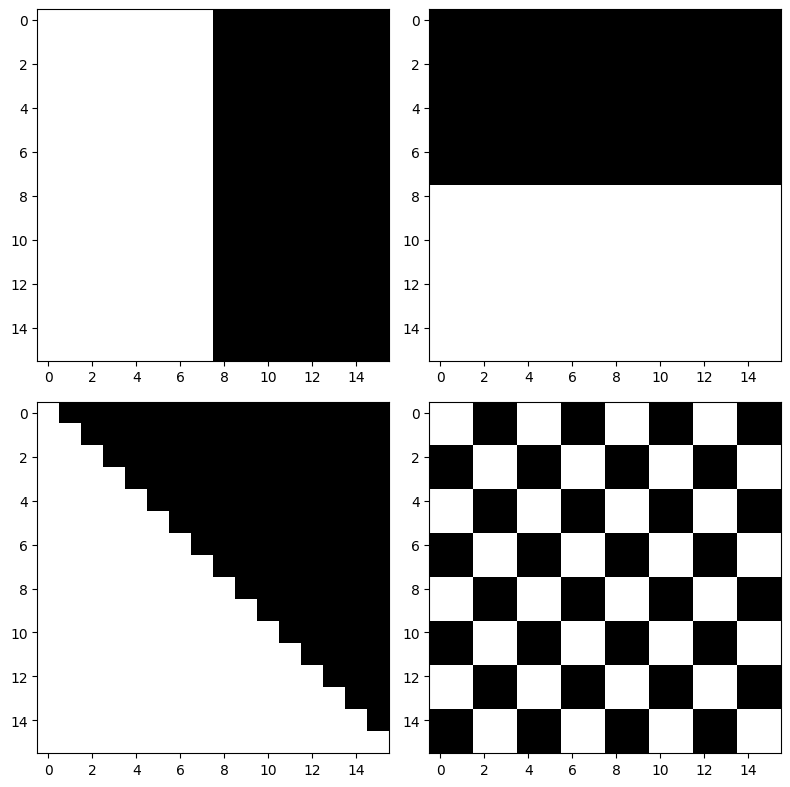

In [618]:
fig,axs = plt.subplots(2,2)
fig.set_size_inches(8,8)
axs[0][0].imshow(img0.squeeze(),cmap="gray")
axs[0][1].imshow(img1.squeeze(),cmap="gray")
axs[1][0].imshow(img2.squeeze(),cmap="gray")
axs[1][1].imshow(img3.squeeze(),cmap="gray")
plt.tight_layout()

In [619]:
imgs = torch.concat([img0,img1,img2,img3])

## B. 세로엣지

In [634]:
v_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=False
)  
v_conv.weight.data =  torch.tensor([
    [0,0,0,0],
    [0,1,  -1, 0],
    [0,1, -1,0],
    [0,0,0,0]
]).float().reshape(1, 1, 4,4)

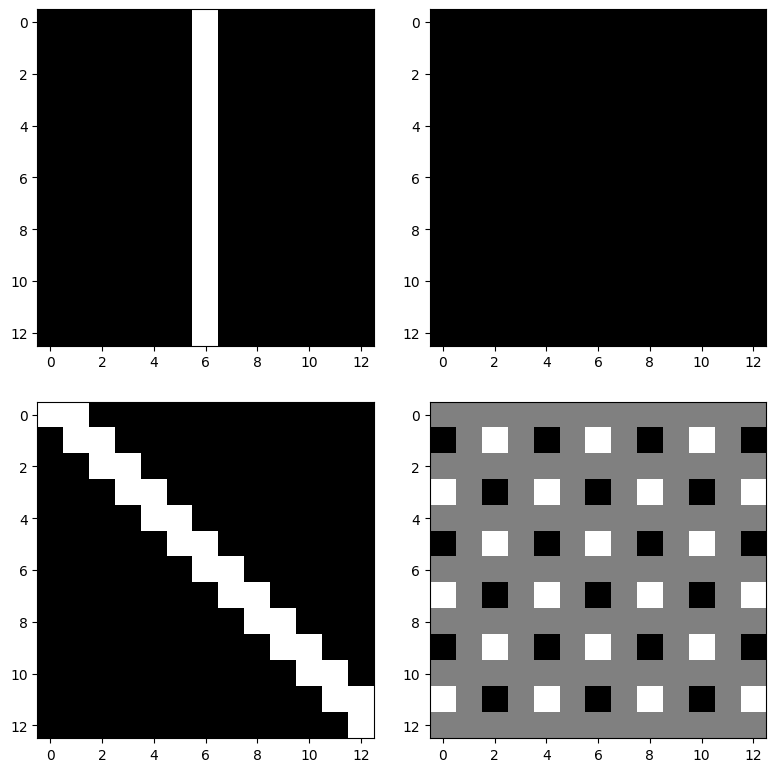

In [635]:
fig,axs = plt.subplots(2,2)
fig.set_size_inches(8,8)
axs[0][0].imshow(v_conv(img0).data.squeeze(), cmap="gray")
axs[0][1].imshow(v_conv(img1).data.squeeze(), cmap="gray")
axs[1][0].imshow(v_conv(img2).data.squeeze(), cmap="gray")
axs[1][1].imshow(v_conv(img3).data.squeeze(), cmap="gray")
plt.tight_layout()

## C. 가로엣지

In [636]:
h_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=False
)  
h_conv.weight.data = torch.tensor([
    [0,0,0,0],
    [0, -1, -1, 0],
    [0, 1, 1, 0],
    [0,0,0,0]
]).float().reshape(1, 1, 4, 4)

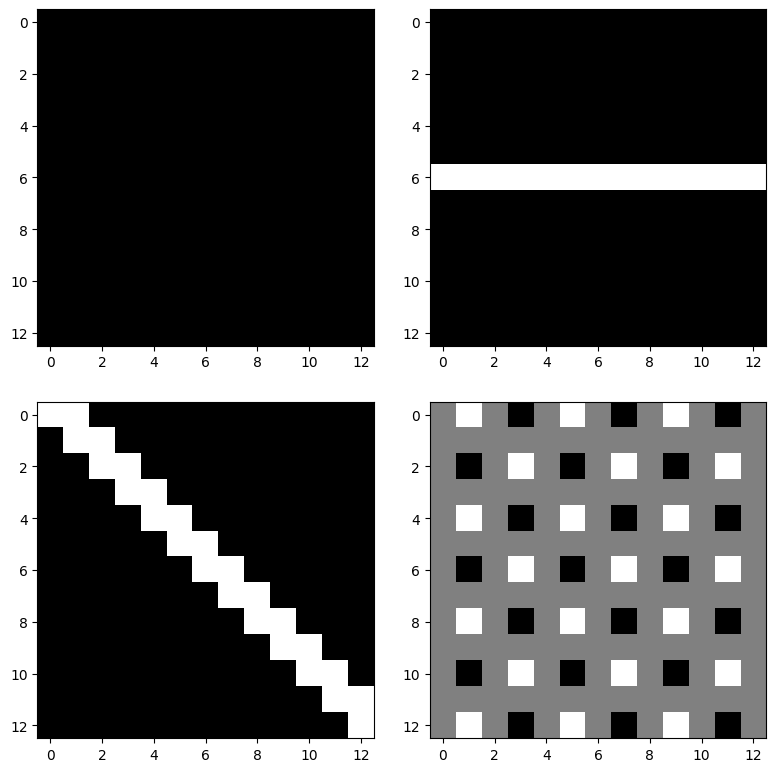

In [637]:
fig,axs = plt.subplots(2,2)
fig.set_size_inches(8,8)
axs[0][0].imshow(h_conv(img0).data.squeeze(),cmap="gray")
axs[0][1].imshow(h_conv(img1).data.squeeze(),cmap="gray")
axs[1][0].imshow(h_conv(img2).data.squeeze(),cmap="gray")
axs[1][1].imshow(h_conv(img3).data.squeeze(),cmap="gray")
plt.tight_layout()

## D. 이동평균

In [639]:
m_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=True
)  
m_conv.weight.data = m_conv.weight.data*0 + 1/4
m_conv.bias.data = m_conv.bias.data*0 -0.2

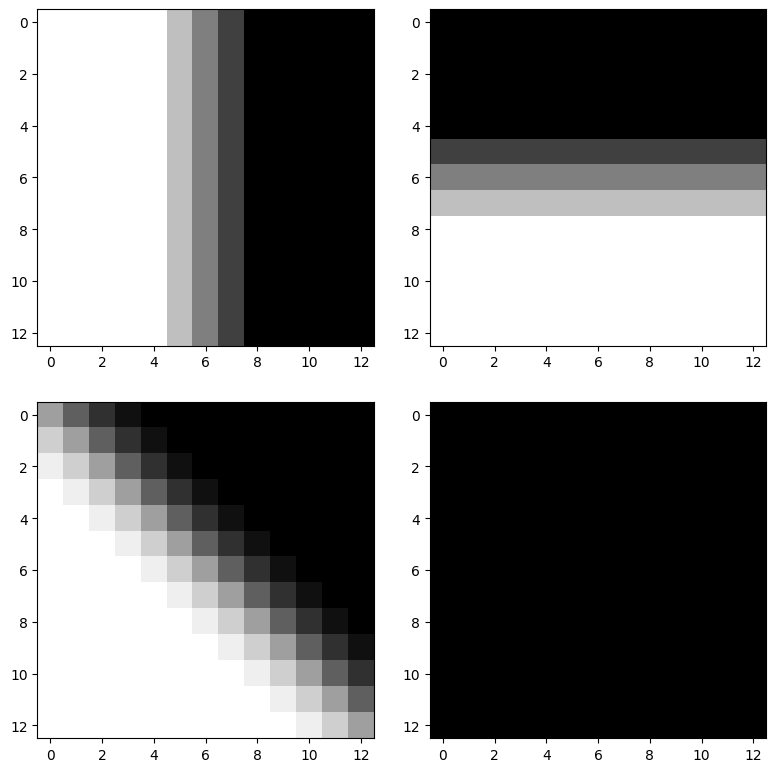

In [640]:
fig,axs = plt.subplots(2,2)
fig.set_size_inches(8,8)
axs[0][0].imshow(m_conv(img0).data.squeeze(), cmap="gray")
axs[0][1].imshow(m_conv(img1).data.squeeze(), cmap="gray")
axs[1][0].imshow(m_conv(img2).data.squeeze(), cmap="gray")
axs[1][1].imshow(m_conv(img3).data.squeeze(), cmap="gray")

plt.tight_layout()

## E. (C,D,E) + relu + mp

In [721]:
relu = torch.nn.ReLU()
mp = torch.nn.MaxPool2d(kernel_size=13)

In [722]:
mp(relu(v_conv(imgs)))

tensor([[[[0.2000]]],


        [[[0.0000]]],


        [[[0.1000]]],


        [[[0.2000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [723]:
mp(relu(h_conv(imgs)))

tensor([[[[0.0000]]],


        [[[0.2000]]],


        [[[0.1000]]],


        [[[0.2000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [724]:
mp(relu(m_conv(imgs)))

tensor([[[[2.0000e-01]]],


        [[[2.0000e-01]]],


        [[[2.0000e-01]]],


        [[[3.7253e-09]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

## F. 대충 이런 구조

In [814]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=3,kernel_size=4),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=13),
    torch.nn.Flatten()
)

In [815]:
net[0].weight.shape

torch.Size([3, 1, 4, 4])

In [816]:
net[0].weight.data = torch.concat(
    [h_conv.weight.data,
     v_conv.weight.data, 
     m_conv.weight.data]
)
net[0].bias.data = torch.tensor([0,0,-0.2])

In [827]:
net(imgs)

tensor([[0.000000e+00, 2.000000e-01, 2.000000e-01],
        [2.000000e-01, 0.000000e+00, 2.000000e-01],
        [1.000000e-01, 1.000000e-01, 2.000000e-01],
        [2.000000e-01, 2.000000e-01, 3.725290e-09]], grad_fn=<ViewBackward0>)

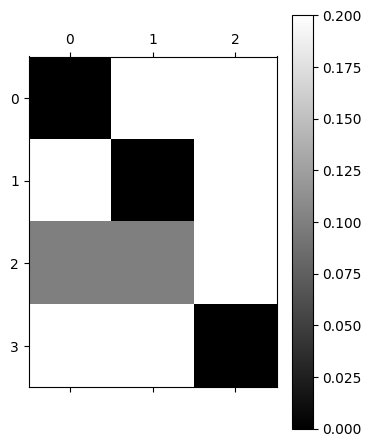

In [833]:
plt.matshow(net(imgs).data,cmap="gray")
plt.colorbar()

## G. mp의 역할? -- 선택

`-` 샘플이미지 

In [859]:
img = torch.zeros((1, 1, 16, 16))
triangle_size = 4
for i in range(triangle_size):
    for j in range(triangle_size):
        if j <= i:  # 아래 방향 직각삼각형 (왼쪽 위 꼭짓점 기준)
            img[0, 0, i, j] = 1.0

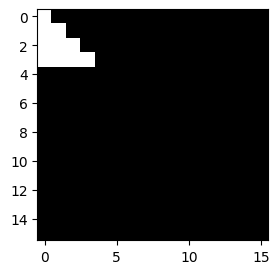

In [868]:
plt.imshow(img.squeeze(),cmap="gray")

`-` mp1 회

In [869]:
mp = torch.nn.MaxPool2d(kernel_size=2)

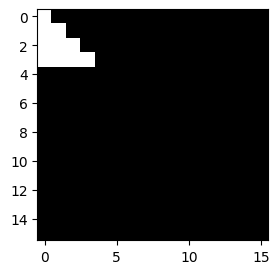

In [870]:
plt.imshow(img.squeeze(),cmap="gray")

`-` mp 2~4회 

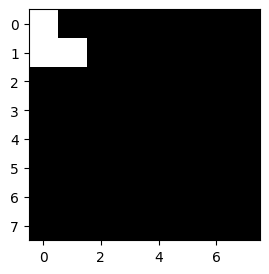

In [871]:
plt.imshow(mp(img).squeeze(),cmap="gray")

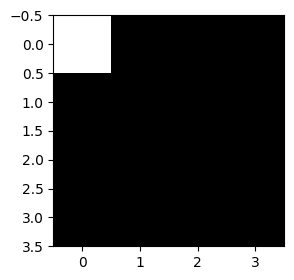

In [872]:
plt.imshow(mp(mp(img)).squeeze(),cmap="gray")

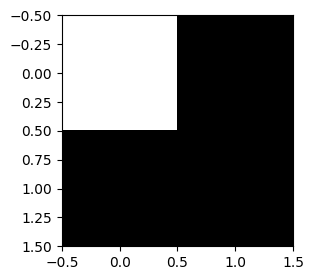

In [873]:
plt.imshow(mp(mp(mp(img))).squeeze(),cmap="gray")

`-` maxpooling은 이미지를 "캐리커처화" 한다고 비유할 수 있음. 디테일은 버리고, 중요한 특징만 뽑아서 과장되게 요약한다. 

# 5. FashionMNIST

`-` 데이터

In [941]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
to_tensor = torchvision.transforms.ToTensor()
X = torch.stack([to_tensor(img) for img, lbl in train_dataset]).to("cuda:0")
y = torch.tensor([lbl for img, lbl in train_dataset])
y = torch.nn.functional.one_hot(y).float().to("cuda:0")

`-` 2d를 처리하고 flatten하는 네트워크 

In [942]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten()
).to("cuda:0")

In [943]:
net1(X).shape

torch.Size([5000, 2304])

`-` 1d를 처리하는 네트워크

In [944]:
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10)
).to("cuda:0")

In [945]:
net2(net1(X)).shape

torch.Size([5000, 10])

`-` 두 네트워크를 결합 

In [946]:
net = torch.nn.Sequential(
    net1,
    net2
)
net(X).shape

torch.Size([5000, 10])

`-` 최종적인 코드 

In [947]:
net = torch.nn.Sequential(
    net1,
    net2
)
optimizr = torch.optim.Adam(net.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
#---#
for epoc in range(150):
    #1
    netout = net(X)
    #2 
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4
    optimizr.step()
    optimizr.zero_grad()    

In [948]:
(net(X).argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.889600, device='cuda:0')